In [322]:
#Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools
import random

In [323]:
#Load the cleaned dataset. The Cleaning of the dataset is done in clean_data.ipynb
df_test = pd.read_csv("./data_10k.csv", sep=',')

In [337]:
#Print the shape of the dataframe, to check the number of recipes and ingredients

print(df_test.shape)
df_test.head()


(10000, 9663)


,id,1-pound chicken butcher piece chicken thigh,1-pound edamame,1-pound lamb,1-pound pizza dough,13. coconut milk,2-layer,2-percent yogurt,6-to salmon,8-pound pork butt cap,...,zucchini plank,zucchini slice,zucchini style tomato sauce,zucchini summer squash,zucchini summer squash piece,zucchini triangle,zucchini zucchini,zuchini,zuchinni,zuchinni chunk
0,6a90237a1f,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,f3234317a4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,fe207a8ce1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,ebd602ad45,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,f38f4ee25d,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


**The dataset contains 10 000 recipes, with 9663 different ingredients. As there are still many outliers in the ingredients, we will clean them later**

In [325]:
df = df_test.set_index("id")

In [326]:
a = pd.DataFrame(df.sum()).sort_values(by=0, ascending=False)
b = pd.DataFrame(df.sum(axis=1)).sort_values(by=0, ascending=False)

In [327]:
translation_recipe_id_index = df_test['id'].reset_index().set_index('id').to_dict()['index']

In [329]:
a[a[0] > 1][:10]

,0
salt,3754.0
sugar,3081.0
onion,2819.0
egg,2282.0
butter,2229.0
flour,1999.0
water,1753.0
pepper,1746.0
olive oil,1456.0
milk,1456.0


In [330]:
# Salt and pepper are often scrapped as only one ingredient
df['pepper'] = df['pepper'] + df['ground pepper']
df['pepper'] = df['pepper'] + df['salt pepper']
df['salt'] = df['salt'] + df['salt pepper']
df['salt'] = df['salt'].clip(0,1)
df['pepper'] = df['pepper'].clip(0,1)

In [224]:
#We want to only keep ingredients present more than once.
columns = a[a[0] > 1].index.values
drop_columns = ["salt ground pepper", "half", "salt pepper", "ground pepper"]
cols = np.setdiff1d(columns, drop_columns)

In [225]:
df_clean = df[cols]

In [226]:
Sortedingredients = pd.DataFrame(df_clean.sum()).sort_values(by=0, ascending=False)

In [227]:
df_clean.shape

(10000, 2754)

In [228]:
df_clean.head()

,2-percent yogurt,aburaage,accompaniment lemon wedge,adobo,adobo sauce,agave nectar,ahi tuna,ale,alfredo sauce,allspice,...,yukon gold potato,yukon gold potato chunk,yuzu juice,zest,zesty,ziti pasta,zucchini,zucchini chunk,zucchini piece,zucchini summer squash
id,,,,,,,,,,,,,,,,,,,,,
6a90237a1f,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
f3234317a4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
fe207a8ce1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ebd602ad45,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
f38f4ee25d,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [229]:
df_clean.isnull().sum().sum()

0

In [230]:
features = df_clean.values
features.shape

(10000, 2754)

In [232]:
nbingredients=features.shape[1]
nbrecettes=features.shape[0]
distancerecipes = compute_euclidean_distance(features)
print(distancerecipes.shape)

distanceingredients=np.zeros((nbingredients, nbingredients))

for i in range(nbrecettes):
    a=features[i]!=0
    listindexingredients=[j for j, x in enumerate(a) if x]
    #print(listindexingredients)
    for pair in itertools.product(listindexingredients, repeat=2):
        #print(pair)
        distanceingredients[pair[0], pair[1]] = distanceingredients[pair[0], pair[1]]+1
for j in range(nbingredients):
    distanceingredients[j,j]=0

(10000, 10000)


In [233]:
meanconnectioningredients=distanceingredients.mean()
mean_distance_recipes = distancerecipes.mean()

****Properties of the ingredients****

In [234]:
Sortedingredients[Sortedingredients[0] > 1][:10]

,0
salt,3754.0
sugar,3081.0
onion,2819.0
egg,2282.0
butter,2229.0
flour,1999.0
water,1753.0
pepper,1746.0
milk,1456.0
olive oil,1456.0


In [235]:
print(distanceingredients.mean())

0.07836650354485375


This is not the mean distance but the mean number of recipes in common between two distinct ingredients.

1459.0


<Figure size 432x288 with 0 Axes>

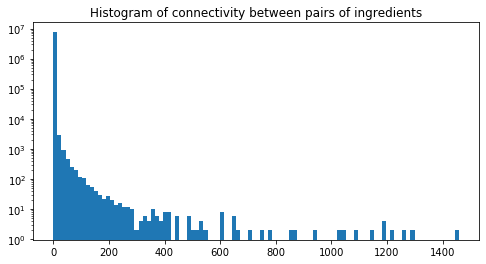

<Figure size 432x288 with 0 Axes>

In [273]:
print(distanceingredients.max())
plt.figure(1, figsize=(8, 4))
plt.title("Histogram of connectivity between pairs of ingredients")
plt.hist(distanceingredients.flatten(), log=True, bins=100)
plt.figure("yo")

In [349]:
Threshold=5
print(sum(sum(distanceingredients>Threshold)))
print(sum(sum(distanceingredients>=Threshold)))

14082
17130


In [350]:
def make_A_feature(distance, threshold, lower_threshold=0):
    A_feature = ((threshold <= distance)).astype(int)
    np.fill_diagonal(A_feature, 0)
    return A_feature

def cleanAfeature(A):
    cleaned=A.copy()
    deleted=0
    for i in range (len(A)):
        if sum( A[len(A)-1-i] )==0:
            deleted+=1
            cleaned=np.delete(cleaned,len(A_feature)-1-i , 0)
            cleaned=np.delete(cleaned,len(A_feature)-1-i, 1)
    print("deleted", deleted)
    return(cleaned)

nb colonnes A_feature 2754
deleted 1973
nb colonnes A_feature_cleaned 781


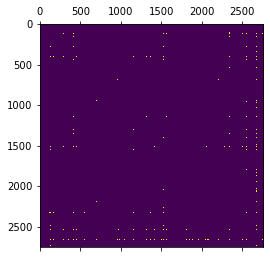

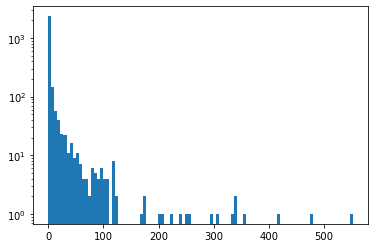

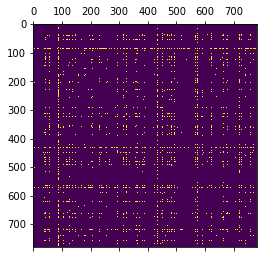

In [351]:
A_feature = make_A_feature(distanceingredients, Threshold)
print('nb colonnes A_feature', len(A_feature))
plt.matshow(A_feature)

A_featurecleaned= cleanAfeature(A_feature)
print('nb colonnes A_feature_cleaned', len(A_featurecleaned))
plt.figure("Degree distribution of the graph cleaned")
plt.hist(sum(A_feature), log=True, bins=100)
plt.matshow(A_featurecleaned)



In [352]:
num_edges_feature = A_featurecleaned.sum() / 2
print(f"Number of edges in the feature cleaned graph: {num_edges_feature}")

Number of edges in the feature cleaned graph: 8565.0


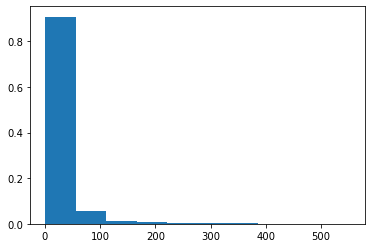

In [353]:
degrees_feature = A_featurecleaned.sum(1)

deg_hist_normalization = np.ones(degrees_feature.shape[0]) / degrees_feature.shape[0]
plt.figure()
plt.hist(degrees_feature, weights=deg_hist_normalization);

In [354]:
degfs, counts_feat = np.unique(degrees_feature, return_counts=True)

degfeatprobs = counts_feat / counts_feat.sum()

feat_moment_1 = (degfs*degfeatprobs).sum()
feat_moment_2 = (degfs*degfs*degfeatprobs).sum()

print(f"1st moment of feature graph: {feat_moment_1}")
print(f"2nd moment of feature graph: {feat_moment_2}")

1st moment of feature graph: 21.933418693982073
2nd moment of feature graph: 3061.134443021767


delete the 20 higher hubs

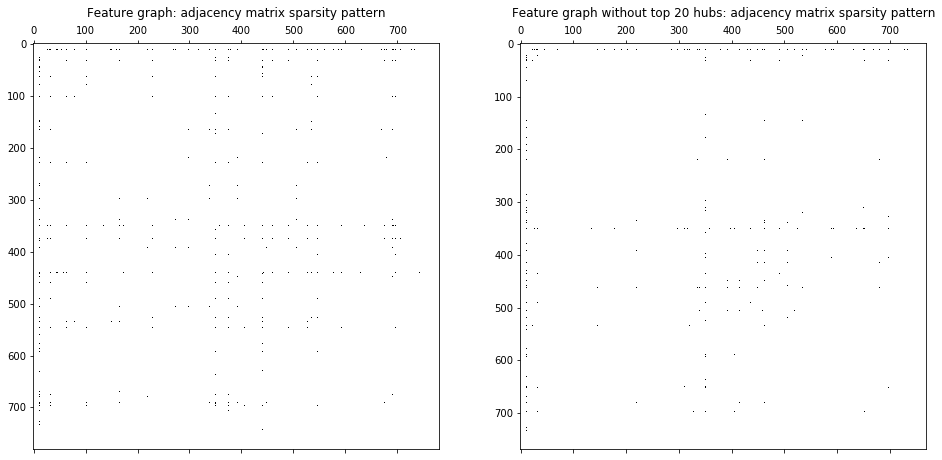

In [355]:
sort_feat = np.argsort(degrees_feature)
#sort_cit = np.argsort(degrees_citation)

reduced_A_feature = A_feature[sort_feat[:-12],:][:, sort_feat[:-12]]

A_feature = A_feature[sort_feat,:][:,sort_feat]
fig, axes = plt.subplots(1, 2, figsize=(16, 16))
axes[0].set_title('Feature graph: adjacency matrix sparsity pattern')
axes[0].spy(A_feature);
axes[1].set_title('Feature graph without top 20 hubs: adjacency matrix sparsity pattern')
axes[1].spy(reduced_A_feature);

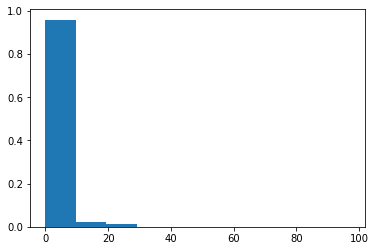

In [356]:
reduced_degrees_feat = reduced_A_feature.sum(1)
#reduced_degrees_cit = reduced_A_citation.sum(1)

deg_hist_normalization = np.ones(reduced_degrees_feat.shape[0]) / reduced_degrees_feat.shape[0]


plt.hist(reduced_degrees_feat, weights=deg_hist_normalization);

In [357]:
reduced_degfs, reduced_counts_feat = np.unique(reduced_degrees_feat,return_counts=True)
reduced_degfeatprobs = reduced_counts_feat / reduced_counts_feat.sum()
reduced_feat_moment_1 = (reduced_degfs*reduced_degfeatprobs).sum()
reduced_feat_moment_2 = (reduced_degfs*reduced_degfs*reduced_degfeatprobs).sum()
print("Feature graph first moment: ", reduced_feat_moment_1)
print("Feature graph second moment: ", reduced_feat_moment_2)

Feature graph first moment:  1.2951885565669699
Feature graph second moment:  34.286085825747726


In [358]:
print("Feat graph edges", reduced_A_feature.sum() / 2)

Feat graph edges 498.0


In [360]:
path_lengths = range(11)

#path_matrix_citation = sum([np.linalg.matrix_power(A_citation, k) for k in path_lengths])
path_matrix_feature = sum([np.linalg.matrix_power(A_feature, k) for k in path_lengths])

In [ ]:

#A AMELIORER POUR MIEUX CONTROLLER LE NOMBRE D'INGREDIENTS
def create_recipe(index_ingredient, nbingredients):
    listneighbours=[]
    listingredients=[index_ingredient]
    for i in range(nbingredients-1):
        #print(listingredients)
        # on prend un ingredient au hasard dans la liste
        choosen = random.choice(listingredients)
        #a:liste
        a=(A_featurecleaned[choosen])
        #print(a)
        #on regarde quels sont ses voisins
        listindneighbouringredients=[j for j, x in enumerate(a) if x]
        listneighbours=list(set(listneighbours+listindneighbouringredients))
        listingredients.append(random.choice(listneighbours))
    return listingredients

In [ ]:
listing=create_recipe(random.randint(0, len(A_featurecleaned)), random.randint(2, 10))
liste=[]
for i in listing:
    liste.append(df_clean.columns[i])
print(list(set(liste)))

**Properties of recipes**

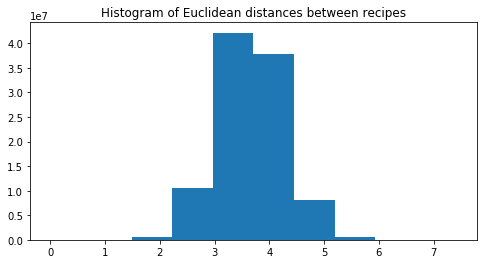

In [248]:
plt.figure(1, figsize=(8, 4))
plt.title("Histogram of Euclidean distances between recipes")
plt.hist(distancerecipes.flatten());

In [249]:
threshold = mean_distance

def compute_euclidean_distance(X):
    return  np.sqrt(-2 * np.dot(X, X.T) + np.sum(X**2, axis=1) + np.expand_dims(np.sum(X**2, axis=1), 1))

def make_A_feature(distance, threshold, lower_threshold=0):
    A_feature = ((lower_threshold <= distance) & (distance < threshold)).astype(int)
    np.fill_diagonal(A_feature, 0)
    return A_feature

A_feature = make_A_feature(distance, threshold)

NameError: name 'mean_distance' is not defined